In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/Users/liangwei/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/liangwei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# ---- 参数定义---- 
cell_size=10       # 隐藏层cell个数
input_size=7       # 输入层维数
time_step = 20     # 步长窗口
output_size=1      # 输出层维数
lr=0.0006         # 学习率
batch_size=60      # 每批次大小
split_line=5800 #前5800行作为训练集

In [3]:
# ---- 数据导入 ---- 
df = pd.read_csv('dataset_2.csv') # 导csv
origin = df.iloc[:,2:].values     # #取第3～10列，一共8列，原始数据(6109, 8)

In [4]:
# 标准化，工具函数
def normal(data):
    mean=np.mean(data,axis=0)
    std=np.std(data,axis=0)
    return (data-mean)/std, mean, std #有三个返回值

In [5]:
# 训练集
#使用前5800行,其中每个输入的x是(20,7)的矩阵，每个输出的y是(20,1)的矩阵，它是20条x对应的y合成的
train,_,_ = normal(origin[:split_line]) # (5800, 8),取normal函数第1个返回值，舍弃后两个返回值
x_train,y_train=[],[]
for i in range(len(train)//time_step): # i=0~5780
    x_train.append(train[i*time_step:(i+1)*time_step,:-1]) #往x_train里放入一个(20,7)的矩阵
    y_train.append(train[i*time_step:(i+1)*time_step,-1,np.newaxis]) 
    #x_train.append( train[i:i+time_step   ,:-1  ] ) #往x_train里放入一个(20,7)的矩阵
    #y_train.append( train[i:i+time_step   ,-1   ,np.newaxis] )

In [6]:
print(len(x_train))
print(np.array(x_train).shape)

#for i in range(len(x_train)):
#    print(i, np.array(x_train[i]).shape)
#for j in range(len(y_train)):
#    print(j, np.array(y_train[j]).shape)

#必须要加各种print才可以看出各种矩阵形状的变化
#for batch in range( len(x_train)//batch_size+1): # 1个周期内批次数
#    start = batch*batch_size 
#    end = min( (batch+1)*batch_size , len(x_train)) 
#    batch_xs = x_train[start : end ]# 获得本批次的x,y
#    batch_ys = y_train[start : end ]
#    print(np.array(batch_xs).shape)


290
(290, 20, 7)


In [7]:
# 测试集
test,mean,std= normal(origin[split_line:])
x_test,y_test=[],[]
for i in range(len(test)//time_step): # (6109-5801)/20 ~= 15
    x_test.append(test[i*time_step:(i+1)*time_step,:-1])
    #y_test.append(test[i*time_step:(i+1)*time_step,-1])
    y_test.extend( test[i*time_step:(i+1)*time_step,-1] ) 

In [8]:
#for i in range(len(x_test)):
#    print(i, np.array(x_test[i]).shape)
#for j in range(len(y_test)):
#    print(j, np.array(y_test[j]).shape)
print(len(x_test))
print(np.array(x_test).shape)
print(len(y_test))
print(np.array(y_test).shape)

15
(15, 20, 7)
300
(300,)


In [9]:
# 定义网络
#X就是输入的数据张量Tensor了，形状为(#data_example, time_step, input_size)的Tensor
X=tf.placeholder(tf.float32, shape=[None,time_step,input_size]) # (Any, 20, 7)
Y=tf.placeholder(tf.float32, shape=[None,time_step,output_size]) # (Any, 20, 1)

#输入层权重、偏置
w1 = tf.Variable(tf.random_normal([input_size,cell_size])) # (7,10)
b1 = tf.Variable(tf.constant(0.1,shape=[cell_size,])) # (10,1)

#输出层权重、偏置
w2 = tf.Variable(tf.random_normal([cell_size,1]))# (10,1)
b2 = tf.Variable(tf.constant(0.1,shape=[1,]))# (1,1)

In [10]:
#定义LSTM
def RNN(x):
    input=tf.reshape(x,[-1,input_size]) # x降维
    input_rnn=tf.matmul(input,w1)+b1
    input_rnn=tf.reshape(input_rnn,[-1,time_step,cell_size])  #将tensor转成3维，作为lstm cell的输入
    cell = tf.nn.rnn_cell.LSTMCell(cell_size) #定义LSTM， block数为cell_size
    output, final_state = tf.nn.dynamic_rnn(cell, input_rnn, dtype=tf.float32)
    output = tf.reshape(output,[-1,cell_size]) 
    result = tf.matmul(output,w2)+b2
    return result

In [11]:
#定义TensorFlow计算
prediction = RNN(X) # 预测
loss = tf.reduce_mean(tf.square(tf.reshape(prediction,[-1])-tf.reshape(Y, [-1]))) # 误差 mean_square(prediction,Y)
train_op=tf.train.AdamOptimizer(lr).minimize(loss) # 训练

Number of iterations: 0  loss: 0.43035868
Number of iterations: 1  loss: 0.38651952
Number of iterations: 2  loss: 0.34302598
Number of iterations: 3  loss: 0.30268532
Number of iterations: 4  loss: 0.2665273
Number of iterations: 5  loss: 0.23498084
Number of iterations: 6  loss: 0.20812462
Number of iterations: 7  loss: 0.18577242
Number of iterations: 8  loss: 0.16752563
Number of iterations: 9  loss: 0.15282807
Number of iterations: 10  loss: 0.14103442
Number of iterations: 11  loss: 0.13148347
Number of iterations: 12  loss: 0.12356163
Number of iterations: 13  loss: 0.116744034
Number of iterations: 14  loss: 0.11060646
Number of iterations: 15  loss: 0.104820184
Number of iterations: 16  loss: 0.09915874
Number of iterations: 17  loss: 0.09352159
Number of iterations: 18  loss: 0.087931044
Number of iterations: 19  loss: 0.08247987
Number of iterations: 20  loss: 0.077268474
Number of iterations: 21  loss: 0.072370194
Number of iterations: 22  loss: 0.06782744
Number of iterati

Number of iterations: 186  loss: 0.0031730377
Number of iterations: 187  loss: 0.0031515646
Number of iterations: 188  loss: 0.0031303957
Number of iterations: 189  loss: 0.0031095194
Number of iterations: 190  loss: 0.0030889292
Number of iterations: 191  loss: 0.0030686145
Number of iterations: 192  loss: 0.0030485706
Number of iterations: 193  loss: 0.0030287893
Number of iterations: 194  loss: 0.0030092665
Number of iterations: 195  loss: 0.0029899906
Number of iterations: 196  loss: 0.0029709607
Number of iterations: 197  loss: 0.0029521643
Number of iterations: 198  loss: 0.0029336005
Number of iterations: 199  loss: 0.0029152604
Number of iterations: 200  loss: 0.0028971394
Number of iterations: 201  loss: 0.0028792322
Number of iterations: 202  loss: 0.0028615368
Number of iterations: 203  loss: 0.0028440417
Number of iterations: 204  loss: 0.0028267486
Number of iterations: 205  loss: 0.0028096458
Number of iterations: 206  loss: 0.0027927356
Number of iterations: 207  loss: 0

Number of iterations: 366  loss: 0.0013441207
Number of iterations: 367  loss: 0.001339236
Number of iterations: 368  loss: 0.0013343428
Number of iterations: 369  loss: 0.0013294771
Number of iterations: 370  loss: 0.001324653
Number of iterations: 371  loss: 0.0013198297
Number of iterations: 372  loss: 0.0013150587
Number of iterations: 373  loss: 0.0013102912
Number of iterations: 374  loss: 0.001305568
Number of iterations: 375  loss: 0.0013008591
Number of iterations: 376  loss: 0.0012961845
Number of iterations: 377  loss: 0.001291533
Number of iterations: 378  loss: 0.0012869091
Number of iterations: 379  loss: 0.0012823131
Number of iterations: 380  loss: 0.001277741
Number of iterations: 381  loss: 0.0012731993
Number of iterations: 382  loss: 0.0012686818
Number of iterations: 383  loss: 0.0012641931
Number of iterations: 384  loss: 0.0012597267
Number of iterations: 385  loss: 0.0012552913
Number of iterations: 386  loss: 0.0012508796
Number of iterations: 387  loss: 0.0012

Number of iterations: 546  loss: 0.0008173634
Number of iterations: 547  loss: 0.0008159087
Number of iterations: 548  loss: 0.00081404124
Number of iterations: 549  loss: 0.00081271527
Number of iterations: 550  loss: 0.00081067235
Number of iterations: 551  loss: 0.00080910575
Number of iterations: 552  loss: 0.0008074872
Number of iterations: 553  loss: 0.00080578675
Number of iterations: 554  loss: 0.0008042793
Number of iterations: 555  loss: 0.00080258166
Number of iterations: 556  loss: 0.0008010249
Number of iterations: 557  loss: 0.0007994102
Number of iterations: 558  loss: 0.0007978046
Number of iterations: 559  loss: 0.0007962316
Number of iterations: 560  loss: 0.00079461804
Number of iterations: 561  loss: 0.0007930483
Number of iterations: 562  loss: 0.0007914535
Number of iterations: 563  loss: 0.0007898826
Number of iterations: 564  loss: 0.0007883133
Number of iterations: 565  loss: 0.0007867491
Number of iterations: 566  loss: 0.0007851987
Number of iterations: 567  

Number of iterations: 725  loss: 0.0013499528
Number of iterations: 726  loss: 0.001975503
Number of iterations: 727  loss: 0.0036698538
Number of iterations: 728  loss: 0.003903454
Number of iterations: 729  loss: 0.0028623417
Number of iterations: 730  loss: 0.0011064603
Number of iterations: 731  loss: 0.0006743642
Number of iterations: 732  loss: 0.00092941476
Number of iterations: 733  loss: 0.0008657766
Number of iterations: 734  loss: 0.00069019065
Number of iterations: 735  loss: 0.00063622394
Number of iterations: 736  loss: 0.0006547888
Number of iterations: 737  loss: 0.00066076155
Number of iterations: 738  loss: 0.0006375708
Number of iterations: 739  loss: 0.0006296733
Number of iterations: 740  loss: 0.000628824
Number of iterations: 741  loss: 0.00062802114
Number of iterations: 742  loss: 0.0006271112
Number of iterations: 743  loss: 0.0006248312
Number of iterations: 744  loss: 0.00062382565
Number of iterations: 745  loss: 0.0006229565
Number of iterations: 746  loss

Number of iterations: 905  loss: 0.00054532074
Number of iterations: 906  loss: 0.00054490945
Number of iterations: 907  loss: 0.00054451084
Number of iterations: 908  loss: 0.0005440997
Number of iterations: 909  loss: 0.0005437089
Number of iterations: 910  loss: 0.00054329407
Number of iterations: 911  loss: 0.00054291607
Number of iterations: 912  loss: 0.0005424924
Number of iterations: 913  loss: 0.00054213713
Number of iterations: 914  loss: 0.00054169615
Number of iterations: 915  loss: 0.0005413878
Number of iterations: 916  loss: 0.00054091716
Number of iterations: 917  loss: 0.00054072565
Number of iterations: 918  loss: 0.00054023525
Number of iterations: 919  loss: 0.00054038846
Number of iterations: 920  loss: 0.00054006715
Number of iterations: 921  loss: 0.00054146815
Number of iterations: 922  loss: 0.00054260826
Number of iterations: 923  loss: 0.0005494596
Number of iterations: 924  loss: 0.00055969844
Number of iterations: 925  loss: 0.0005941616
Number of iteration

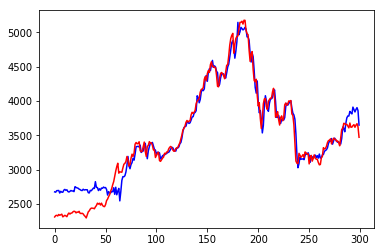

In [12]:
#训练
# ---- 训练 ---- 
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(1000):     #训练10个周期
        #for batch in range( len(train)//batch_size  ): # 这个地方把原来的改掉了
        for batch in range( len(x_train)//batch_size+1): # 1个周期内批次数
            start = batch*batch_size 
            end = min( (batch+1)*batch_size , len(x_train)) 
            batch_xs, batch_ys =  x_train[start : end ], y_train[start : end ] # 获得本批次的x,y
            _,loss_= sess.run([train_op, loss],feed_dict={X:batch_xs, Y:batch_ys}) # 训练
        print("Number of iterations:",epoch," loss:",loss_)
    print("The train has finished")
    # 开始测试
    y_pred=[]
    for x in  x_test :
        y=sess.run(prediction,feed_dict={X:[x]})
        y_pred.extend(y.reshape((-1)))
    y_test=np.array(y_test)*std[7]+mean[7]
    y_pred=np.array(y_pred)*std[7]+mean[7]
    acc=np.average(np.abs(y_pred-y_test[:len(y_pred)])/y_test[:len(y_pred)])  # 精确度
    print("The accuracy of this predict:",acc)
    #以折线图表示结果
    plt.figure()
    plt.plot(list(range(len(y_pred))), y_pred, color='b',)
    plt.plot(list(range(len(y_test))), y_test,  color='r')
    plt.show()